In [11]:
# Import Libraries
import requests
import pandas as pd
import numpy as np
import datetime

# SpaceX API URL
spacex_url = "https://api.spacexdata.com/v4/launches/past"
response = requests.get(spacex_url)
response_json = response.json()

# Convert API to DataFrame
data = pd.json_normalize(response_json)
data = data[['rocket','payloads','launchpad','cores','flight_number','date_utc']]

# API Helper Functions
def getBoosterVersion(data):
    BoosterVersion = []
    for x in data['rocket']:
        if x:
            r = requests.get(f"https://api.spacexdata.com/v4/rockets/{x}").json()
            BoosterVersion.append(r['name'])
    return BoosterVersion

def getLaunchSite(data):
    LaunchSite, Longitude, Latitude = [], [], []
    for x in data['launchpad']:
        if x:
            r = requests.get(f"https://api.spacexdata.com/v4/launchpads/{x}").json()
            LaunchSite.append(r['name'])
            Longitude.append(r['longitude'])
            Latitude.append(r['latitude'])
    return LaunchSite, Longitude, Latitude

def getPayloadData(data):
    PayloadMass, Orbit = [], []
    for x in data['payloads']:
        if x:
            r = requests.get(f"https://api.spacexdata.com/v4/payloads/{x[0]}").json()
            PayloadMass.append(r.get('mass_kg', np.nan))
            Orbit.append(r.get('orbit'))
    return PayloadMass, Orbit

def getCoreData(data):
    Outcome, Reused, GridFins, Legs, Block, ReusedCount = [], [], [], [], [], []
    for c in data['cores']:
        if c[0]['core'] is not None:
            core = requests.get(f"https://api.spacexdata.com/v4/cores/{c[0]['core']}").json()
            Outcome.append(str(c[0]['landing_success']) + " " + str(c[0]['landing_type']))
            Reused.append(c[0]['reused'])
            GridFins.append(c[0]['gridfins'])
            Legs.append(c[0]['legs'])
            Block.append(core.get('block'))
            ReusedCount.append(core.get('reuse_count'))
        else:
            Outcome.append(None)
            Reused.append(None)
            Block.append(None)
            ReusedCount.append(None)
    return Outcome, Reused, GridFins, Legs, Block, ReusedCount

# Apply Data Extraction
data['BoosterVersion'] = getBoosterVersion(data)
data['PayloadMass'], data['Orbit'] = getPayloadData(data)
data['LaunchSite'], data['Longitude'], data['Latitude'] = getLaunchSite(data)
data['Outcome'], data['Reused'], data['GridFins'], data['Legs'], data['Block'], data['ReusedCount'] = getCoreData(data)

# Filter Falcon 9
data = data[data['BoosterVersion'] != 'Falcon 1']
data = data.reset_index(drop=True)
data.to_csv('dataset_part1.csv', index=False)

In [14]:
import pandas as pd
import numpy as np

df = pd.read_csv("dataset_part1.csv")

# Replace Missing PayloadMass
df['PayloadMass'] = df['PayloadMass'].fillna(df['PayloadMass'].mean())

# Outcome Classification
landing_outcomes = df['Outcome'].value_counts()
bad_outcomes = set(landing_outcomes.keys()[[1,3,5,6,7]])
landing_class = df['Outcome'].apply(lambda x: 0 if x in bad_outcomes else 1)
df['Class'] = landing_class

df.to_csv('dataset_part2.csv', index=False)

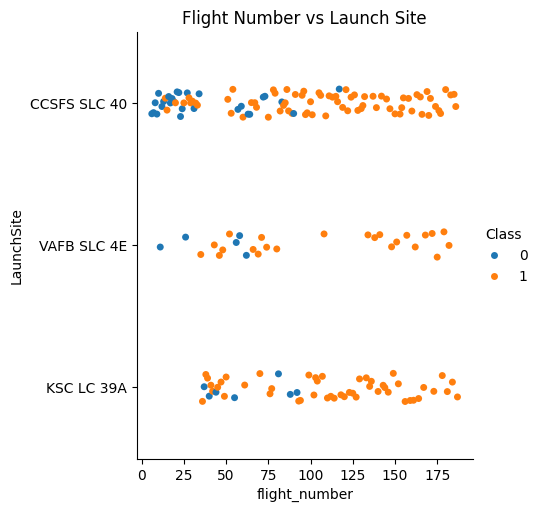

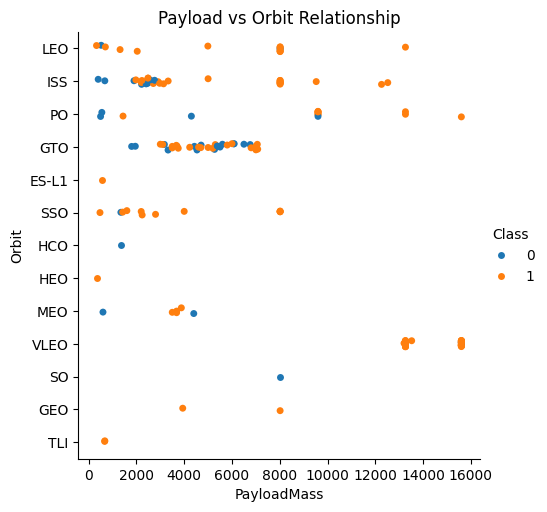

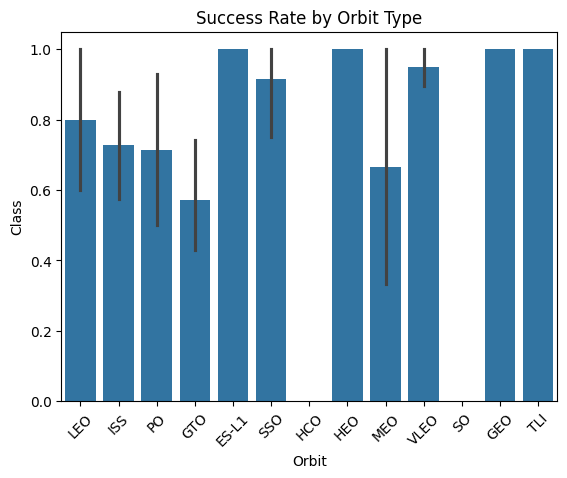

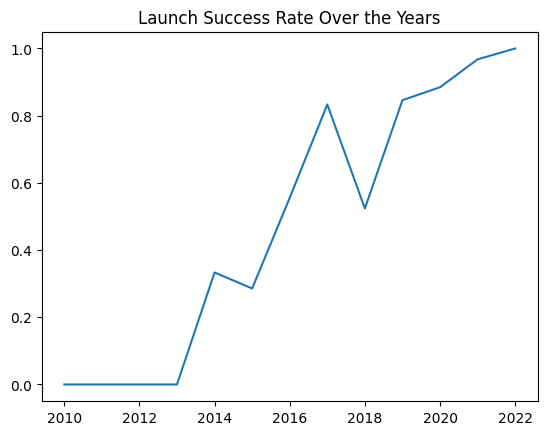

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

df = pd.read_csv("dataset_part2.csv")

# Flight Number vs Launch Site
sns.catplot(x="flight_number", y="LaunchSite", hue="Class", data=df)
plt.title("Flight Number vs Launch Site")
plt.show()

# Payload Mass vs Orbit Type
sns.catplot(x="PayloadMass", y="Orbit", hue="Class", data=df)
plt.title("Payload vs Orbit Relationship")
plt.show()

# Success Rate by Orbit
sns.barplot(x=df["Orbit"], y=df["Class"])
plt.xticks(rotation=45)
plt.title("Success Rate by Orbit Type")
plt.show()

# Success Rate by Year
df['Year'] = pd.to_datetime(df['date_utc']).dt.year
yearly_success = df.groupby('Year')['Class'].mean()
plt.plot(yearly_success)
plt.title("Launch Success Rate Over the Years")
plt.show()

# Feature Encoding for ML
features = df[['flight_number','PayloadMass','Orbit','LaunchSite','Block','Reused','Legs','GridFins']]
features = pd.get_dummies(features, columns=['Orbit','LaunchSite'])
features = features.astype('float64')
features.to_csv('dataset_part3.csv', index=False)

In [17]:
import sqlite3
con = sqlite3.connect("spacex.db")
df = pd.read_csv("dataset_part2.csv")
df.to_sql("SPACEXTABLE", con, if_exists="replace", index=False)

# Example Queries
cur = con.cursor()
# 1. Unique Launch Sites
print(cur.execute("SELECT DISTINCT LaunchSite FROM SPACEXTABLE;").fetchall())

# 2. Average Payload per Booster Version
print(cur.execute("SELECT BoosterVersion, AVG(PayloadMass) FROM SPACEXTABLE GROUP BY BoosterVersion;").fetchall())

# 3. First Ground Landing Success
print(cur.execute("SELECT MIN(date_utc) FROM SPACEXTABLE WHERE Outcome LIKE '%True RTLS%';").fetchall())

[('CCSFS SLC 40',), ('VAFB SLC 4E',), ('KSC LC 39A',)]
[('Falcon 9', 8104.318614946771), ('Falcon Heavy', 2650.0)]
[('2015-12-22T01:29:00.000Z',)]


In [19]:
import folium
import pandas as pd
from folium.plugins import MarkerCluster

spacex_df = pd.read_csv("dataset_part2.csv")
map_sites = folium.Map(location=[29.559684, -95.083097], zoom_start=5)

marker_cluster = MarkerCluster().add_to(map_sites)
for _, row in spacex_df.iterrows():
    color = 'green' if row['Class'] == 1 else 'red'
    folium.Marker(
        [row['Latitude'], row['Longitude']],
        popup=row['LaunchSite'],
        icon=folium.Icon(color=color)
    ).add_to(marker_cluster)

map_sites.save("spacex_launch_sites.html")

In [21]:
!pip install dash dash-core-components dash-html-components dash-bootstrap-components plotly

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 54.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.0/204.0 kB 14.6 MB/s eta 0:00:00


In [23]:
from dash import Dash, html, dcc, Input, Output
import pandas as pd
import plotly.express as px

df = pd.read_csv('dataset_part2.csv')

app = Dash(__name__)

app.layout = html.Div([
    html.H1("SpaceX Launch Dashboard"),
    dcc.Dropdown(
        id='site-dropdown',
        options=[{'label': i, 'value': i} for i in df['LaunchSite'].unique()] + [{'label': 'All Sites', 'value': 'ALL'}],
        value='ALL',
    ),
    dcc.Graph(id='success-pie'),
    html.Br(),
    html.P("Payload Range (Kg):"),
    dcc.RangeSlider(id='payload-slider', min=0, max=10000, step=1000, value=[0,10000]),
    dcc.Graph(id='success-payload-scatter')
])

@app.callback(
    Output('success-pie', 'figure'),
    Input('site-dropdown', 'value')
)
def update_pie(site):
    if site == 'ALL':
        fig = px.pie(df, names='LaunchSite', values='Class', title='Total Success across Sites')
    else:
        filtered = df[df['LaunchSite'] == site]
        fig = px.pie(filtered, names='Class', title=f'Success Rate for {site}')
    return fig

@app.callback(
    Output('success-payload-scatter', 'figure'),
    [Input('site-dropdown','value'), Input('payload-slider','value')]
)
def update_scatter(site, payload):
    low, high = payload
    filtered = df[(df['PayloadMass'] >= low) & (df['PayloadMass'] <= high)]
    if site != 'ALL':
        filtered = filtered[filtered['LaunchSite'] == site]
    fig = px.scatter(filtered, x='PayloadMass', y='Class', color='Orbit', title='Payload vs Success')
    return fig

if __name__ == '__main__':
    app.run(debug=True)


<IPython.core.display.Javascript object>

In [24]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

data = pd.read_csv("dataset_part3.csv")
labels = pd.read_csv("dataset_part2.csv")['Class']

X = StandardScaler().fit_transform(data)
Y = labels
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=2)

# Logistic Regression
param = {'C':[0.01,0.1,1], 'solver':['lbfgs']}
logreg_cv = GridSearchCV(LogisticRegression(), param, cv=10)
logreg_cv.fit(X_train, Y_train)
print("Best LR params:", logreg_cv.best_params_)
print("LR test score:", logreg_cv.best_estimator_.score(X_test, Y_test))

# Decision Tree
param_tree = {'max_depth': range(2,10), 'criterion':['gini','entropy']}
tree_cv = GridSearchCV(DecisionTreeClassifier(), param_tree, cv=10)
tree_cv.fit(X_train, Y_train)
print("Best Tree params:", tree_cv.best_params_)
print("Tree test score:", tree_cv.best_estimator_.score(X_test, Y_test))

# KNN
param_knn = {'n_neighbors': range(1,10), 'p':[1,2]}
knn_cv = GridSearchCV(KNeighborsClassifier(), param_knn, cv=10)
knn_cv.fit(X_train, Y_train)
print("Best KNN params:", knn_cv.best_params_)
print("KNN test score:", knn_cv.best_estimator_.score(X_test, Y_test))

# SVM
param_svm = {'kernel':['linear','rbf','poly'], 'C':[0.1,1,10]}
svm_cv = GridSearchCV(SVC(), param_svm, cv=10)
svm_cv.fit(X_train, Y_train)
print("Best SVM params:", svm_cv.best_params_)
print("SVM test score:", svm_cv.best_estimator_.score(X_test, Y_test))


Best LR params: {'C': 0.1, 'solver': 'lbfgs'}
LR test score: 0.918918918918919
Best Tree params: {'criterion': 'entropy', 'max_depth': 2}
Tree test score: 0.918918918918919
Best KNN params: {'n_neighbors': 9, 'p': 2}
KNN test score: 0.918918918918919
Best SVM params: {'C': 0.1, 'kernel': 'linear'}
SVM test score: 0.918918918918919
